# Matching General Use Case

Matching is a widely used causal inference analysis tool, the main idea is to improve statistical model performance by preprocessing data with nonparametric or non-parametric matching methods. After preprocessing data with CausalMatch, researchers can use whatever parametric model they would have used without CausalMatch, but produce inferences with substantially more robustness and less sensitivity to modeling assumptions.

### Data

We have following types of observations:
* Covariates, which we will denote with `X`
* Treatment, which we will denote with `T`
* Responses, which we will denote with `Y`

Requirement is that `T` is a binary varible which contain only 0/1 values.


In [1]:
import sys
print(sys.path)
sys.path.append('/Users/bytedance/PycharmProjects/github/CausalMatch')

import causalmatch as causalmatch
from causalmatch import matching,gen_test_data

print('current version is: ',causalmatch.__version__)

import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)


import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score,roc_auc_score,f1_score
import statsmodels.api as sm

['/Library/Frameworks/Python.framework/Versions/3.12/lib/python312.zip', '/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12', '/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/lib-dynload', '', '/Users/bytedance/Library/Python/3.12/lib/python/site-packages', '/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages']
current version is:  0.0.2
/usr/local/bin/python3.12
3.12.2 (v3.12.2:6abddd9f6a, Feb  6 2024, 17:02:06) [Clang 13.0.0 (clang-1300.0.29.30)]
sys.version_info(major=3, minor=12, micro=2, releaselevel='final', serial=0)


## 1. Generate synthetic data for example

In [2]:
df, rand_continuous, rand_true_param, param_te , rand_treatment, rand_error = gen_test_data(n = 10000, c_ratio=0.5)
X = ['c_1', 'c_2', 'c_3', 'd_1', 'gender']
y = ['y', 'y2']
id = 'user_id'

# treatment variable has to be a 0/1 dummy variable
# if is string, please convert to a 0/1 int input
T = 'treatment'

## 2. PSM Demo
###  2.1 Simple PSM

In [3]:
# -------------------------------------------------------- #
# STEP 1: initialize matching object
match_obj = matching(data = df,
                     T = T,
                     X = X,
                     id = id)
# -------------------------------------------------------- #

# STEP 2: propensity score matching
match_obj.psm(n_neighbors = 1,  # number of neighbors
              model = GradientBoostingClassifier(), # p-score model
              trim_percentage = 0.1, # trim X% of pscore, if equals 0.1 then trim min 5% and max 5%
              caliper = 0.1,
              verbose = True) # p-score diff must be smaller than or equal to the caliper value

# # if you with to keep all matched observations
# match_obj.psm(n_neighbors = 1, 
#               model = GradientBoostingClassifier(), 
#               trim_percentage = 0, 
#               caliper = 1) 

# -------------------------------------------------------- #

# STEP 3: balance check after propensity score matching
res_post, res_pre = match_obj.balance_check(include_discrete = True)
print('post-matching balance check reseult',res_post) # pre-match balance check
print('pre-matching balance check reseult',res_pre)  # post-match balance check

# -------------------------------------------------------- #

# STEP 4: sensitivity test
match_obj.y = y
df_sensitivity_test = match_obj.sensitivity_test(gamma = [1,1.5,2,2.5])
print('sensitivity test result: ', df_sensitivity_test)

# -------------------------------------------------------- #

# STEP 5: get result - pandas df, and merge X and y back to original data
print('Output dataframe columns', match_obj.df_out_final_post_trim.columns)
df_out = match_obj.df_out_final_post_trim.merge(df[y + X + [id]], how='left', on = id)

# -------------------------------------------------------- #

# STEP 6: calculate average treatment effect 

X_mat = df_out[T]
y_mat = df_out[y]

X_mat = sm.add_constant(X_mat)
model = sm.OLS(y_mat,X_mat)
results = model.fit()
print(results.params)


Processed Samples: 100%|████████████| 5097/5097 [00:00<00:00, 812402.34sample/s]

******************************
post-matching balance check reseult        Covariates  Mean Treated post-match  Mean Control post-match   SMD  \
0             c_1                   0.5052                   0.5145 -0.03   
1             c_2                   0.5026                   0.4954  0.03   
2             c_3                   0.5090                   0.5003  0.03   
3         d_1_bee                   0.1123                   0.1097  0.01   
4         d_1_cat                   0.1584                   0.1446  0.04   
5         d_1_dog                   0.1934                   0.1828  0.03   
6        d_1_pear                   0.2567                   0.2787 -0.05   
7     gender_cat1                   0.0721                   0.0708  0.01   
8     gender_cat2                   0.0865                   0.0861  0.00   
9     gender_cat3                   0.1717                   0.2007 -0.08   
10    gender_cat4                   0.0210                   0.0151  0.04   
11    gen

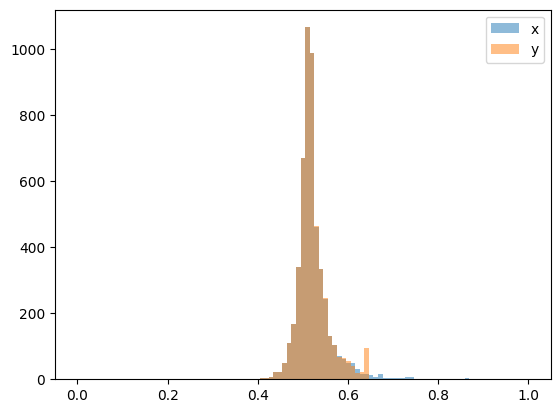

In [4]:
from matplotlib import pyplot
bins = np.linspace(0, 1, 100)

pyplot.hist(match_obj.df_out_final['pscore_treat'].values, bins, alpha=0.5, label='x')
pyplot.hist(match_obj.df_out_final['pscore_control'].values, bins, alpha=0.5, label='y')
pyplot.legend(loc='upper right')
pyplot.show()

### 2.2 PSM with multiple p-score model

In [5]:
# STEP 0: Define all p-score models you want to fit
ps_model1 = LogisticRegression(C=1e6)
ps_model2 = SVC(probability=True)
ps_model3 = GaussianNB()
ps_model4 = KNeighborsClassifier()
ps_model5 = DecisionTreeClassifier()
ps_model6 = RandomForestClassifier()
ps_model7 = GradientBoostingClassifier()
ps_model8 = LGBMClassifier()
ps_model9 = XGBClassifier()


# --  STEP 0: we chooise model with the best f1 score
model_list = [ps_model1, ps_model2, ps_model3, 
              ps_model4, ps_model5, ps_model6, 
              ps_model7, ps_model8, ps_model9]


# STEP 1: initialize matching object
match_obj = matching(data = df,     
                     T = T,
                     X = X,
                     id = id)

# STEP 2: propensity score matching
match_obj.psm(n_neighbors = 1,
              model_list = model_list, # input list of models you want to try
              trim_percentage = 0,
              caliper = 1,              
              test_size = 0.2) # train-test split, what portion does test sample takes



# STEP 3: balance check after propensity score matching
print(match_obj.balance_check(include_discrete = True))


# STEP 4: obtain average partial effect 
# -- match_obj.df_out_final_post_trim is the post matching dataframe afrer 
# -- trimming observations based on caliper and p-score percentage

print('Output dataframe columns', match_obj.df_out_final_post_trim.columns)
df_out = match_obj.df_out_final_post_trim.merge(df[y + X + [id]], how='left', on = id)

X_mat = df_out[T]
y_mat = df_out[y]

X_mat = sm.add_constant(X_mat)
model = sm.OLS(y_mat,X_mat)
results = model.fit()
print(results.params)

[LightGBM] [Info] Number of positive: 4077, number of negative: 3923
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 791
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509625 -> initscore=0.038505
[LightGBM] [Info] Start training from score 0.038505
The f1 score for all models you specify is: [0.5773809523809523, 0.5805354866128347, 0.6130055511498811, 0.5143134400776322, 0.5076242006886375, 0.5004793863854267, 0.5656050955414013, 0.5198863636363636, 0.5149928605425987]
The best model is the 2 model
(       Covariates  Mean Treated post-match  Mean Control post-match   SMD  \
0             c_1                   0.5004                   0.4999  0.00   
1             c_2                   0.5024                   0.5040 -0.01   
2             c_3        

### 2.3 PSM with ATE generated for you


In [6]:
# STEP 0: Define all p-score models you want to fit
ps_model1 = LogisticRegression(C=1e6)
ps_model2 = SVC(probability=True)
ps_model3 = GaussianNB()
ps_model4 = KNeighborsClassifier()
ps_model5 = DecisionTreeClassifier()
ps_model6 = RandomForestClassifier()
ps_model7 = GradientBoostingClassifier()
ps_model8 = LGBMClassifier()
ps_model9 = XGBClassifier()


# we chooise model with best f1 score
model_list = [ps_model1, ps_model2]


# STEP 1: initialize matching object
match_obj = matching(data = df,     
                     T = T,
                     X = X,
                     y = y, # you have to identify dependent variable name if want to use ATE function
                     id = id)

# STEP 2: propensity score matching
match_obj.psm(n_neighbors = 1,
              model = LogisticRegression(C=1e6), # input list of models you want to try
              trim_percentage = 0,
              caliper = 1,              
              test_size = 0.2) # train-test split, what portion does test sample takes



# STEP 3: balance check after propensity score matching
print(match_obj.balance_check(include_discrete = True))


# STEP 4: obtain average partial effect 
print(match_obj.ate())

(       Covariates  Mean Treated post-match  Mean Control post-match   SMD  \
0             c_1                   0.5004                   0.4984  0.01   
1             c_2                   0.5024                   0.5027 -0.00   
2             c_3                   0.5033                   0.5031  0.00   
3         d_1_bee                   0.1124                   0.1034  0.03   
4         d_1_cat                   0.1581                   0.1727 -0.04   
5         d_1_dog                   0.1929                   0.1878  0.01   
6        d_1_pear                   0.2551                   0.2466  0.02   
7     gender_cat1                   0.0714                   0.0667  0.02   
8     gender_cat2                   0.0883                   0.0963 -0.03   
9     gender_cat3                   0.1683                   0.1752 -0.02   
10    gender_cat4                   0.0247                   0.0290 -0.03   
11    gender_cat5                   0.1156                   0.1279 -0.04  

## 3. CEM
### 3.1 Simple CEM

In [7]:
# STEP 1: initialize matching object
match_obj_cem = matching(data = df, 
                         y = ['y'],
                         T = 'treatment', 
                         X = ['c_1','d_1','d_3'],
                         id = 'user_id')

# STEP 2: coarsened exact matching
match_obj_cem.cem(n_bins = 10, # number of bins you set to divide continuous variables, user pd.qcut function to obatin
                  k2k = True)  # k2k: make sure number of treatment equals number of control. if is false, you need to apply weighted least square to obtain ATE


# STEP 3: balance check after propensity score matching
print(match_obj_cem.balance_check(include_discrete=True))

# STEP 4: obtain average partial effect 
print(match_obj_cem.ate())



number of matched obs (9768, 15) number of total obs  (10000, 15)
(   Covariates  Mean Treated post-match  Mean Control post-match   SMD  \
0         c_1                   0.4999                   0.4983  0.01   
1     d_1_bee                   0.1114                   0.1194 -0.03   
2     d_1_cat                   0.1546                   0.1570 -0.01   
3     d_1_dog                   0.1929                   0.2002 -0.02   
4    d_1_pear                   0.2588                   0.2545  0.01   
5     d_3_1.0                   0.2039                   0.1882  0.04   
6     d_3_2.0                   0.0516                   0.0516  0.00   
7     d_3_3.0                   0.1790                   0.1804 -0.00   
8     d_3_4.0                   0.0704                   0.0713 -0.00   
9     d_3_5.0                   0.0692                   0.0676  0.01   
10    d_3_6.0                   0.0921                   0.0938 -0.01   
11    d_3_7.0                   0.1824                   

### 3.2 CEM with customized bin
If your continuous variable feature is very skewed, use customized breakpoint instead of percentile cut.

In [8]:



# STEP 1: initialize matching object
match_obj_cem = matching(data = df, 
                       y = ['y'],
                       T = 'treatment', 
                       X = ['c_1','d_1','d_3'],
                       id = 'user_id')

# STEP 2: coarsened exact matching
match_obj_cem.cem(n_bins = 10, 
                  
                  # continuous feature c_1 break down to 5 bins based on customized breakpoing
                  # ->[-inf,-1),[-1, 0.3), [0.3, 0.6), [0.6, 2),[2,inf]
                  break_points = {'c_1': [-1, 0.3, 0.6, 2]}, 
                  
                  # discrete/string features group to a bigger group:
                  # -- 1. d_1 has 5 values, customize to a 3 value group
                  # -- 2. d_3 has 10 values, customize to a 3 value group
                  cluster_criteria = {'d_1': [['apple','pear'],['cat','dog'],['bee']],
                                      'd_3': [['0.0','1.0','2.0'],
                                                ['3.0','4.0','5.0'],
                                                ['6.0','7.0','8.0','9.0']]},
                  k2k = True) 


# STEP 3: balance check after propensity score matching
print(match_obj_cem.balance_check(include_discrete=True))

# -- match result is stored in this dataframe: match_obj_cem.df_out_final
Y = match_obj_cem.df_out_final['y']
X = match_obj_cem.df_out_final['treatment']
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
print(results.params['treatment'],results.pvalues['treatment'])


# STEP 4: obtain average partial effect 
print('ATE using OLS: ',match_obj_cem.ate())
print('ATE using WLS: ',match_obj_cem.ate(use_weight=True))


number of matched obs (9806, 15) number of total obs  (10000, 15)
(   Covariates  Mean Treated post-match  Mean Control post-match   SMD  \
0         c_1                   0.5002                   0.4984  0.01   
1     d_1_bee                   0.1103                   0.1201 -0.03   
2     d_1_cat                   0.1575                   0.1577 -0.00   
3     d_1_dog                   0.1934                   0.1997 -0.02   
4    d_1_pear                   0.2549                   0.2541  0.00   
5     d_3_1.0                   0.2025                   0.1874  0.04   
6     d_3_2.0                   0.0512                   0.0514 -0.00   
7     d_3_3.0                   0.1783                   0.1797 -0.00   
8     d_3_4.0                   0.0706                   0.0710 -0.00   
9     d_3_5.0                   0.0687                   0.0673  0.01   
10    d_3_6.0                   0.0930                   0.0934 -0.00   
11    d_3_7.0                   0.1813                   